doc skipped after longitude mean test
doc skipped after longitude mean test
doc skipped after longitude mean test
doc skipped after lat long search
doc skipped after lat long search
doc skipped after lat long search


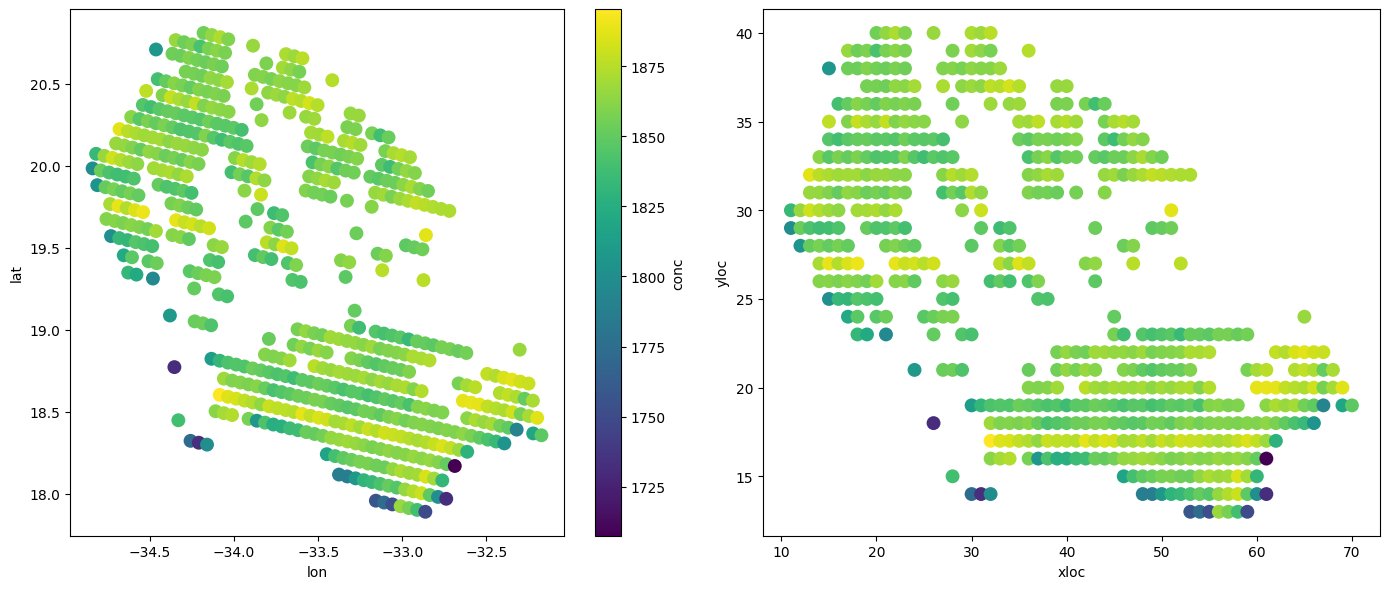

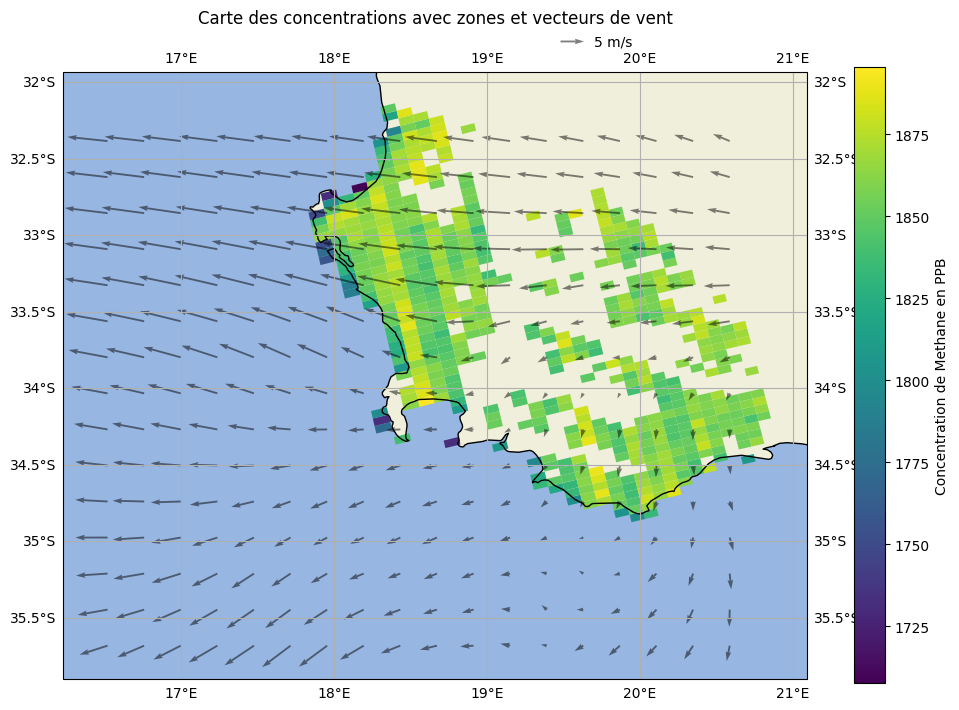

no plume found in image
no plume found in image
emissions totales= 0.0 tonnes par heures
latlon= [-33.90570614  18.66454998]


In [9]:
import sys
import math
import matplotlib.pyplot as plt
from scipy import ndimage
from math import radians, cos, sin, asin, sqrt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import ee
import pickle
import numpy as np
from matplotlib.animation import FuncAnimation
import requests  
from io import BytesIO
import csv
from PIL import Image
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import netCDF4 as nc
import os
import time as tm

"""
##############################################################################################################################################
PICKLE EXTRACTION
##############################################################################################################################################
"""

"""FUNCTIONS"""

def test_date_and_time(date, time, filename):
    # DATE HOUR ORBITAL NUMBER FETCHING
    date_and_time = filename.split("_")[8].split("T")
    file_date = int(date_and_time[0])
    file_time_utc = int(date_and_time[1])
    return date == file_date
# HAVERSINE FUNCTION - DISTANCE 
def deg_to_rad(degrees):
    return degrees * (math.pi / 180)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad = deg_to_rad(lat1)
    lon1_rad = deg_to_rad(lon1)
    lat2_rad = deg_to_rad(lat2)
    lon2_rad = deg_to_rad(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


def stop_enougn_data(dico):
    selected_long = dico["longitude"]
    if len(selected_long) > 0:
        return (
            haversine_distance(
                latitude,
                np.abs(max(selected_long) - longitude),
                latitude,
                np.abs(min(selected_long) - longitude),
            )
            <= 20
        )
    else:
        return False


def demasquage(list, replace, valeur_max):
    new_list = []
    for i in range(len(list)):
        if np.isnan(list[i]) or list[i] >= valeur_max:
            new_list.append(replace)
        else:
            new_list.append(list[i])
    return new_list



def change_key_name(dico, key, new_key):
    new_dic = dico
    new_dic[new_key] = dico[key]
    del new_dic[key]
    return new_dic


""" MAIN """


def main():
    directory = "data"
    dico = {}
    DIMENSIONS = [
        "latitude",
        "longitude",
        "sp",
        "lat0",
        "lat1",
        "lat2",
        "lat3",
        "lon0",
        "lon1",
        "lon2",
        "lon3",
        "xloc",
        "yloc",
        "methane_mixing_ratio",
        "methane_mixing_ratio_precision",
        "methane_mixing_ratio_bias_corrected",
    ]

    for dim in DIMENSIONS:
        dico[dim] = []

    #ANALYSIS VARIABLES 
    count = 0
    max_count = 2

    #PRINT VARIABLES 
    skipcount = 0
    successcount = 0

    for filename in os.listdir(directory):
        #print(f"{filename} opened")

        # vérification pértinence fichier :l'heure et la date
        if (
            test_date_and_time(date, time, filename)
            and count <= max_count
            and not stop_enougn_data(dico)
        ):

            # Lecture du fichier
            rootgrp = nc.Dataset(
                f"data\{filename}",
                "r",
                format="NETCDF4",
            )

            
            max_long_diff_from_mean = 40
            longitudes_list = rootgrp["PRODUCT"]["longitude"][0]
            latitudes_list = rootgrp["PRODUCT"]["latitude"][0]
            longueur, largeur = np.shape(longitudes_list)
            moyenne_longitude = sum([sum(i) for i in longitudes_list]) / (
                longueur * largeur
            )

            #print(f"moyenne longitude={moyenne_longitude}")
            if np.abs(moyenne_longitude - longitude) <= max_long_diff_from_mean:
                #print(f"longueur={longueur} et largeur={largeur}")
                #MORE PRECISE PIXEL SORT 

                file_relevant = False

                for i in range(longueur):
                    for j in range(largeur):
                        if (
                            haversine_distance(
                                latitude,
                                longitude,
                                latitudes_list[i, j],
                                longitudes_list[i, j],
                            )
                            < max_dist
                        ):
                            file_relevant = True
                            break

                if file_relevant:
                    #THE FILE IS USABLE
                    count += 1

                    #FETCHING VALUES
                    pressure_list = np.array(
                        rootgrp["PRODUCT"]["SUPPORT_DATA"]["INPUT_DATA"][
                            "surface_pressure"
                        ][0]
                    )

                    pixel_boudaries_lat = rootgrp["PRODUCT"]["SUPPORT_DATA"][
                        "GEOLOCATIONS"
                    ]["latitude_bounds"][:][0]
                    pixel_boudaries_long = rootgrp["PRODUCT"]["SUPPORT_DATA"][
                        "GEOLOCATIONS"
                    ]["longitude_bounds"][:][0]

                    dico_list = {}
                    for dim in DIMENSIONS[-3:]:
                        dico_list[dim] = np.array(rootgrp["PRODUCT"][dim][0])

                    #metadata
                    dico["orbit"] = int(filename.split("_")[10])
                    dico["date"] = date
                    dico["latlon"] = [latitude, longitude]


                    for j in range(largeur):
                        max_dist_lat_for_fixed_long = np.inf
                        for i in range(longueur):
                            lat = latitudes_list[i, j]
                            long = longitudes_list[i, j]
                            #pixel relevance test
                            if np.abs(lat - latitude) < max_dist_lat_for_fixed_long:

                                if (
                                    haversine_distance(latitude, longitude, lat, long)
                                    < max_dist
                                ):

                                    dico["longitude"].append(long)
                                    dico["latitude"].append(lat)

                                    #adding the useful dimensions
                                    for dim in DIMENSIONS[-3:]:
                                        dico[dim].append(dico_list[dim][i, j])

                                    # xloc, yloc
                                    dico["xloc"].append(i)
                                    dico["yloc"].append(j)

                                    #add pressure 
                                    dico["sp"].append(pressure_list[i, j])

                                    #adding pixel corners 
                                    pixel_boudaries_lat_ij = pixel_boudaries_lat[i, j]
                                    pixel_boudaries_long_ij = pixel_boudaries_long[i, j]
                                    dico["lat0"].append(pixel_boudaries_lat_ij[0])
                                    dico["lat1"].append(pixel_boudaries_lat_ij[1])
                                    dico["lat2"].append(pixel_boudaries_lat_ij[2])
                                    dico["lat3"].append(pixel_boudaries_lat_ij[3])
                                    dico["lon0"].append(pixel_boudaries_long_ij[0])
                                    dico["lon1"].append(pixel_boudaries_long_ij[1])
                                    dico["lon2"].append(pixel_boudaries_long_ij[2])
                                    dico["lon3"].append(pixel_boudaries_long_ij[3])

                                
                                    successcount += 1
                                    if successcount > 50:
                                        #print("50 successes")
                                        successcount = 0
                                else:
                                    max_dist_lat_for_fixed_long = np.abs(lat - latitude)
                            else:
                                skipcount += 1

                                if skipcount >= 4000:
                                    #print(f"4000 skiped, col={j}")

                                    skipcount = 0
                    if count == 1:
                        dico["xloc"] = np.array(dico["xloc"]) - min(dico["xloc"])
                        dico["yloc"] = np.array(dico["yloc"]) - min(dico["yloc"])

                else:
                    print("doc skipped after lat long search")
            else:
                print("doc skipped after longitude mean test")
    if dico == {}:
        print("ERROR : NO MATCH FOUND IN THIS DATASET")
        return {}

    for dim in DIMENSIONS[-3:]:
        dico[dim] = demasquage(dico[dim], np.nan, 10**9)

    dico = change_key_name(dico, "methane_mixing_ratio", "conc")
    dico = change_key_name(dico, "latitude", "lat")
    dico = change_key_name(dico, "longitude", "lon")
    for dim in list(dico.keys()):
        dico[dim] = np.array(dico[dim])
    return dico

def generate_map():
    t1 = tm.time()
    objs = main()
    t2 = tm.time()
    dt = t2 - t1
    
    #print(f"durée d'exécution :{dt} sec")
    fig = plt.figure(figsize=(14, 6))
    
    import pickle
    
    # "result_search_{latitude}_{longitude}_{date}.pkl"
    with open(f"map.pkl", "wb") as f:
        pickle.dump(objs, f)
    
    #first subplot (work in progress, checking for eventual anomalies)
    ax1 = plt.subplot(1, 2, 1)
    col = objs["conc"]
    
    plt.scatter(
        objs["lat"],
        objs["lon"],
        c=col,
        marker="o",
        s=100,
        cmap="viridis",
        linewidths=0.0,
    )
    
    plt.xlabel("lon")
    plt.ylabel("lat")
    plt.colorbar(label="conc")
    
    # second subplot 
    ax2 = plt.subplot(1, 2, 2)
    plt.scatter(
        objs["xloc"],
        objs["yloc"],
        c=col,
        marker="o",
        s=100,
        cmap="viridis",
        linewidths=0.0,
    )
    
    plt.xlabel("xloc")
    plt.ylabel("yloc")
    plt.tight_layout()
    plt.show()



"""
##############################################################################################################################################
PARAMS
##############################################################################################################################################
"""
np.set_printoptions(threshold=sys.maxsize)
sdstep=1                                      ## admitted mean deviation ( in standard deviations ) for a concentration to be considered in the plume
file_in = './map.pkl'               ##### File name containing example data


"""
##############################################################################################################################################
DATA READING FUNCTIONS 
#############################################################################################################################################
"""

def plot_concentration_map(map_data):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12, 8))
    [X, Y, ewwind, nswind] = generatewindmap(map_data)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)
    conc = map_data['conc']
    lat = map_data['lat']
    lon = map_data['lon']
    mask = map_data['mask']
    lat0 = map_data['lat0']
    lat1 = map_data['lat1']
    lat2 = map_data['lat2']
    lat3 = map_data['lat3']
    lon0 = map_data['lon0']
    lon1 = map_data['lon1']
    lon2 = map_data['lon2']
    lon3 = map_data['lon3']
    cmap = plt.get_cmap('viridis')
    vmin=np.inf
    vmax=0
    for i in range(len(lat0)):
        if not np.isnan(conc[i]):
            if conc[i]>vmax:
                vmax=conc[i]
            if conc[i]<vmin:
                vmin=conc[i]
    norm = Normalize(vmin=vmin, vmax=vmax)
    for i in range(len(lat0)):
        if mask[i]==0:
            polygon_coords = [(lon0[i], lat0[i]), (lon1[i], lat1[i]), (lon2[i], lat2[i]), (lon3[i], lat3[i])]
            color = cmap(norm(conc[i]))
            polygon = Polygon(polygon_coords, closed=True, edgecolor='none', facecolor=color, transform=ccrs.PlateCarree())
            ax.add_patch(polygon)
        else:
            polygon_coords = [(lon0[i], lat0[i]), (lon1[i], lat1[i]), (lon2[i], lat2[i]), (lon3[i], lat3[i])]
            color = cmap(norm(conc[i]))
            polygon = Polygon(polygon_coords, closed=True, edgecolor=(1, 0.4, 0.4, 0.8), facecolor=color, transform=ccrs.PlateCarree())
            ax.add_patch(polygon)
    plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', label='Concentration de Methane en PPB')
    quiver=ax.quiver(X, Y, ewwind, nswind, transform=ccrs.PlateCarree(), color=(0, 0, 0, 0.5),width=0.0025)
    ax.quiverkey(quiver, X=0.7, Y=1.05, U=5, label='5 m/s', labelpos='E')
    plt.title('Carte des concentrations avec zones et vecteurs de vent',pad=20)
    plt.savefig('map1.png')
    plt.show()



def plot_matrix_scatter(matrix):
    # Convert the matrix to a numpy array
    matrix = np.array(matrix)
    # Get the coordinates of the ones in the matrix
    ones_positions = np.argwhere(matrix == 1)
    # Split the coordinates into x and y components
    x, y = ones_positions[:, 1], ones_positions[:, 0]
    # Create the scatter plot
    plt.scatter(x, y, c='blue', marker='s')
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix row/column indexing
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.title('Scatter Plot of Matrix')
    plt.grid(True)
    plt.show()


def addminmax(map):
   minlat=float(min(map['lat']))
   maxlon=float(max(map['lon']))
   minlon=float(min(map['lon']))
   maxlat=float(max(map['lat']))
   map['extr']=[minlat,maxlon,minlon,maxlat]

def read_pickle(nnn):
   objects = []
   with (open(nnn, "rb")) as openfile:
      while True:
         try:
            objects.append(pickle.load(openfile))
         except EOFError:
            break
   return objects



def extraire_colonne_csv(nom_fichier):
    valeurs_colonne = []
    with open(nom_fichier, "r") as fichier_csv:
        lecteur_csv = csv.reader(fichier_csv)
        en_tete = next(lecteur_csv)  # Ignorer la première ligne (en-tête)
        index_colonne = en_tete.index("source_rate_t/h")
        for ligne in lecteur_csv:
            valeurs_colonne.append(float(ligne[index_colonne]))  # Convertir en nombre si nécessaire
    return valeurs_colonne



"""
##############################################################################################################################################
PLUME RELATED ALGORITHMS
#############################################################################################################################################
"""


def findplumesource2(map):     
    '''
    returns the x and y location of a plume source from the latitude and longitude of the source 
    '''
    
    lat,lon=map['latlon']
    mindist=np.inf
    N=len(map['conc'])
    for i in range(N):
        idist=haversine(lat,lon,map['lat'][i],map['lon'][i])
        if idist<mindist:
            mindist=idist
            Ind=i
    return(map['xloc'][Ind],map['yloc'][Ind])


def findplumesource(map):     
    '''
    returns the x and y location of a plume source from the latitude and longitude of the source 
    '''
    lat,lon=map['latlon']
    maxdist=0
    N=len(map['conc'])
    for i in range(N):
        idist=haversine(lat,lon,map['lat'][i],map['lon'][i])
        if idist>maxdist:
            maxdist=idist
    dist=maxdist/20
    maxconc=0
    for i in range(N):
        idist=haversine(lat,lon,map['lat'][i],map['lon'][i])
        if idist<maxdist:
            if map['conc'][i]>maxconc:
                maxconc=map['conc'][i]
                Ind=i
    return(map['xloc'][Ind],map['yloc'][Ind])


def addplume(map,xloc,yloc,threshold):    
   """
    adds the plume to the dictionnary with a proximity algorithm
   """
   N=len(map['conc'])
   miny=min(map['yloc'])
   maxy=max(map['yloc'])
   minx=min(map['xloc'])
   maxx=max(map['xloc'])
   I=maxy-miny+1             
   J=maxx-minx+1
   map['mask']=np.zeros(N,dtype=int)
   npmap=np.zeros((I,J))

   for i in range(N):
      npmap[map['yloc'][i]-miny][map['xloc'][i]-minx]=map['conc'][i]
   plumematrix=np.zeros((I,J))
   plumematrix[yloc-miny][xloc-minx]=1
   Exitcondition=False

   while not Exitcondition:
      Ni=np.count_nonzero(plumematrix == 1)
      plumematrix=ndimage.binary_dilation(plumematrix).astype(plumematrix.dtype)
      for i in range(I):
         for j in range(J):
            if plumematrix[i][j]==1:
               if np.isnan(npmap[i][j]):
                  plumematrix[i][j]=0
               else:
                  if npmap[i][j]<threshold:
                     plumematrix[i][j]=0
      #plot_matrix_scatter(plumematrix)
                  
      Nj=np.count_nonzero(plumematrix == 1)
      if Ni==Nj:
         Exitcondition=True
   for i in range(N):
      if plumematrix[map['yloc'][i]-miny][map['xloc'][i]-minx]==1:
         map['mask'][i]=1


def haversine(lat1, lon1, lat2, lon2):
    """
    calculates the distance between two points from their coordinates in meters
    """
    lon1 = math.radians(lon1)        
    lat1 = math.radians(lat1)
    lon2 = math.radians(lon2)
    lat2 = math.radians(lat2)
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2    
    c = 2 * asin(sqrt(a)) 
    r = 6371000 
    return c * r



"""
##############################################################################################################################################
EMISSIONS RELATED ALGORITHMS
#############################################################################################################################################
"""


def calc_area(map,i):
    '''
    returns area of a rectangle on the map in sqmeters
    '''
    d1=haversine(map['lat0'][i],map['lon0'][i],map['lat1'][i],map['lon1'][i])     
    d2=haversine(map['lat1'][i],map['lon1'][i],map['lat2'][i],map['lon2'][i])   
    #print("(mètres) d1=",d1,"d2=",d2)
    return d1*d2


def calc_mass(cppb,press,area):
    #print(cppb,press,area)
    '''
    calculates the mass of methane in a given area in kgs
    '''
    airmass=(press/9.81)*area
    nmolecules=(airmass/0.0289)    
    nCh4=cppb*nmolecules/1000000000         
    mCh4=nCh4*0.01604               
    return mCh4
    

def gettruemean(map):
    N=len(map['conc'])
    Nconcval=0
    truemean=0                      #calcul de la moyenne de concentration en ppb hors panache 
    for i in range(N):
          if not np.isnan(map['conc'][i]):
              if map['mask'][i]==0:                  #le pixel n'est pas dans le panache 
                  truemean=truemean+map['conc'][i]
                  Nconcval=Nconcval+1
    truemean=truemean/Nconcval
    return truemean


def calc_emissions(map):
    '''
    Calculates the total emissions of a plume in kg.s-1 with ime method
    '''
    N=len(map['conc'])
    IME=0
    total_area=0

    NS_Wind = np.load('NS_Wind.npy')
    EW_Wind = np.load('EW_Wind.npy')
    I,J=np.shape(NS_Wind)[0],np.shape(NS_Wind)[1]
    speeds=0
    for i in range(I):
        for j in range(J):
            speeds=speeds+np.sqrt(NS_Wind[i][j]**2+EW_Wind[i][j]**2)
    windspeed=speeds/(I*J)
    #print("mean windspeed=",windspeed)
    truemean=gettruemean(map)
    #print("mean methane ppb outside the plume=",truemean)
    
    for i in range(N):
        if map['mask'][i]==1:
            area=calc_area(map,i)
            total_area=total_area+area
            IME=IME+calc_mass(map['conc'][i]-truemean ,map['sp'][i],area)  
    if total_area==0: #no plume found in area
        IME=0
        print('no plume found in image')
    else:
        IME=IME/np.sqrt(total_area)
        IME=IME*windspeed
    return(IME)

def getthreshold(map):
    
    """Calculates the Ch4 ppb threshold for a pixel to belong in the plume based on 
    the number of admitted standard deviations"""

    N=len(map['conc'])
    Nconcval=0
    mean=0                      #Mean Ch4 value in the area
    for i in range(N):
          if not np.isnan(map['conc'][i]):
             mean=mean+map['conc'][i]
             Nconcval=Nconcval+1
    mean=mean/Nconcval
    sd=0                        #Standard deviation of methane concentrations in the area
    for i in range(N):      
       if not np.isnan(map['conc'][i]):
          sd=sd+(map['conc'][i]-mean)**2
    sd=sd/Nconcval
    sd=np.sqrt(sd)
    threshold=mean+sd*sdstep
    return threshold



"""
##############################################################################################################################################
WIND DATA RELATED FUNCTIONS
#############################################################################################################################################
"""


def generatewindmap(map):
   addminmax(map)
   date=map['date']
   minlat,maxlon,minlon,maxlat=map['extr']
   return (generatewindtable(float(minlon),float(minlat),float(maxlon),float(maxlat),date))
    

def generatewindtable( minlong ,minlat ,maxlong ,maxlat,date):
    date_str = str(date)
    date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    dataset="NASA/GEOS-CF/v1/rpl/tavg1hr"
    ee.Initialize()
    roi = ee.Geometry.Rectangle([minlong,minlat ,maxlong , maxlat ])
    dataset = ee.ImageCollection(dataset) \
              .filterBounds(roi) \
              .filterDate(date)  \
              .sort('system:time_start') \
              .select(['U10M','V10M'])
    datalist = dataset.toList(dataset.size().getInfo())
    nimages = datalist.size().getInfo()
    tablesList=[]
    for i in range(nimages):                              #In case there's multiple images - to animate the wind map for example 
        image = ee.Image(datalist.get(i))
        band_arrs = image.sampleRectangle(region=roi,defaultValue=0) 
        EW_data_table = np.array( band_arrs.get('U10M').getInfo() ) 
        NS_data_table = np.array( band_arrs.get('V10M').getInfo() ) 
        date_milliseconds = image.date().getInfo()['value']
        tablesList.append({"EW_Wind":EW_data_table,"date":date_milliseconds,"NS_Wind":NS_data_table})          
    nLat=len(tablesList[0]['EW_Wind'])
    nLong=len(tablesList[0]['EW_Wind'][0])
    latstep= (maxlat-minlat)/nLat
    longstep=(maxlong-minlong)/nLong
    X = np.arange(minlong, maxlong,longstep)
    Y = np.arange(minlat,maxlat,latstep)
    X, Y = np.meshgrid(X, Y)
    tablesList[0]['EW_Wind']=np.array(tablesList[0]['EW_Wind'])
    tablesList[0]['NS_Wind']=np.array(tablesList[0]['NS_Wind'])
    np.save('EW_Wind.npy',tablesList[0]['EW_Wind'])
    np.save('NS_Wind.npy',tablesList[0]['NS_Wind'])
    np.save('Longitudes.npy',X)
    np.save('Lattitudes.npy',X)
    return(X, Y, tablesList[0]['EW_Wind'], tablesList[0]['NS_Wind'])


"""
####################################################################
EXECUTION
####################################################################

### NOTE : DUE TO CLOUD REPARTITION IN SOME AREAS DATA MAY BE UNUSABLE - IN THAT CASE TRY DIFFERENT DATES 

"""

#AREA PARAMETERS 

max_dist = 200  
date, time, latitude, longitude = 20230713, 134052,  -33.90570613773499, 18.664549979534655


generate_map()





objs = read_pickle(file_in)                     ##### read the file with example data
nobjs = len(objs)                               ## Number of objects
emissions=[]
for io in range(nobjs):
    map=objs[io]
    xloc,yloc=findplumesource2(map)
    threshold=getthreshold(map)
    addplume(map,xloc,yloc,threshold)
    plot_concentration_map(map)
    emissions.append(calc_emissions(map)*3.6)
    print("emissions totales=",calc_emissions(map)*3.6,"tonnes par heures")
    print("latlon=",map['latlon'])


nom_fichier_csv = "sron_data.csv"
valeurs_source_rate = extraire_colonne_csv(nom_fichier_csv)





In [ ]:



def compare_lists_by_index(list1, list2):
    #fonction de comparaison entre les résultats de notre algortithme et ceux du sron 
    if len(list1) != len(list2):
        raise ValueError("Les deux listes doivent être de taille égale.")

    indices = np.arange(len(list1))
    width = 0.35  # Largeur des barres

    fig, ax = plt.subplots()
    bars1 = ax.bar(indices - width/2, list1, width, label='Données calculées')
    bars2 = ax.bar(indices + width/2, list2, width, label='Données du Sron')

    ax.set_xlabel('Numéro de carte')
    ax.set_ylabel('débit méthane (tonnes.s-1) ')
    ax.set_title('Comparaison des valeurs calculées et de référence')
    ax.set_xticks(indices)
    ax.legend()

    plt.show()
compare_lists_by_index(emissions,valeurs_source_rate)

In [2]:
ee.Authenticate(force=True)
#authentification earth engine nécéssaire à l'éxecution via api 

Enter verification code:  4/1AQlEd8zueVk6VP4GXjqFNCcGVVQuu3jqHwdm9aUazs5wD-r9S91yODfGUOM



Successfully saved authorization token.
